In [ ]:
# install verdict
!uv pip install verdict --system

# data
!wget https://raw.githubusercontent.com/nlpyang/geval/refs/heads/main/results/gpt4_coh_detailed.json --no-clobber

# This notebook has been run ahead of time, so you can inspect outputs without making
# any API calls. You can set your API key if you want to run the examples yourself.
# %env OPENAI_API_KEY=*************************

> [**G-Eval: NLG Evaluation using GPT-4 with Better Human Alignment**](https://arxiv.org/abs/2303.16634)  
> Yang Liu, Dan Iter, Yichong Xu, Shuohang Wang, Ruochen Xu, Chenguang Zhu  
> EMNLP 2023

In [12]:
import pandas as pd
from verdict.dataset import DatasetWrapper
from verdict.schema import Schema

df = pd.read_json("./gpt4_coh_detailed.json")
df['coherence'] = df['scores'].apply(lambda x: x['coherence'])

dataset = DatasetWrapper.from_pandas(
    df[['source', 'system_output', 'coherence']],
    columns=['source', 'system_output']
)

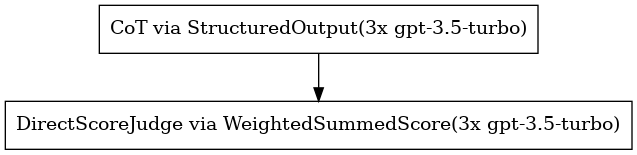

In [13]:
from verdict import Pipeline
from verdict.common.cot import CoTUnit
from verdict.common.judge import JudgeUnit
from verdict.scale import DiscreteScale
from verdict.extractor import WeightedSummedScoreExtractor

TASK = """You will be given one summary written for a news article.

Your task is to rate the summary on one metric.

Please make sure you read and understand these instructions carefully. Please keep this document open while reviewing, and refer to it as needed.

Evaluation Criteria:
    Coherence (1-5) - the collective quality of all sentences. We align this dimension with the DUC quality question of structure and coherence whereby ”the summary should be well-structured and well-organized. The summary should not just be a heap of related information, but should build from sentence to sentence to a coherent body of information about a topic.
"""

pipeline = Pipeline("GEval") \
    >> CoTUnit().prompt(f"""
        Generate evaluation steps for the following task:

        {TASK}

        Evaluation Steps:
    """).via("gpt-3.5-turbo", retries=3, temperature=0.0) \
    >> JudgeUnit(DiscreteScale((1, 5))).prompt(f"""
        {TASK}

        Evaluation Steps:

        {{previous.thinking}}


        Example:


        Source Text:

        {{source.source}}

        Summary:

        {{source.system_output}}


        Evaluation Form (scores ONLY):

        - Coherence:
        """).extract(WeightedSummedScoreExtractor()).via("gpt-3.5-turbo", retries=3, temperature=0.0)

pipeline.plot()

In [14]:
results_df, leaf_node_prefixes = pipeline.run_from_dataset(dataset['all'], max_workers=512)

In [15]:
from verdict.util.experiment import ExperimentConfig, display_stats

display_stats(
    results_df,
    ExperimentConfig(
        ground_truth_cols=["coherence"],
        prediction_cols=leaf_node_prefixes
    ));

───────────────────────────────────────────────────────────────────────────────────────────────────────────────── 
                                                                                            Cohen   Kend…   Spea…  
  Ground Truth   Prediction                                                         Acc.     (κ)     (τ)     (ρ)   
 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────── 
     coherence   GEval_root.block.unit[CoT].block.unit[DirectScoreJudge]_score      0.00%     —     0.13    0.19   
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────